# MODELO DE ISING 

# Fases Magnéticas
<img src="FasesPNG.png">

El hamiltoniano de Ising se puede escribir como, 

$$ 
\mathcal{H} = -J \sum_{\langle i j \rangle} S_{i} S_{j}-h\sum_{\langle i}S_{i} .  
$$

* El spins $S_{i}$ puede tomar valores $\pm 1$,
*  $\langle i j \rangle$ Implica solo la interacción vecino más cercano, 
* $J>0$ es la fuerza de la interacción de intercambio..
* $h$ es Intensidad de campo magnetico externo

$$ 
\mathcal{H} = -J \sum_{\langle i j \rangle} S_{i} S_{j}
$$

Parametro de magnetización

$$ m = \frac{1}{N}\sum_{\langle i} S_i $$


   Si $J>0$ los espines vecinos prefieren ser paralelos (ferromagnetismo).
   
   Si $J<0$ los espines vecinos prefieren ser antiparalelos (anti ferromagnetismo).

Un sistema en equilibrio térmico con un baño de temperatura. Probabilidad $P_\mu$ de estar en estado $\mu$ con energía $E\mu$ es

$$P_\mu=\frac{1}{Z}e^{-\beta E_\mu} \hspace{2 cm} Z=\sum_\mu e^{-\beta E_\mu} \hspace{2 cm} P_{\mu}P(\mu\rightarrow\upsilon)=P_{\upsilon}P(\upsilon\rightarrow\mu) \hspace{2 cm} \frac{P_{\mu}}{P_{\upsilon}}=\frac{P(\mu\rightarrow\upsilon)}{P(\upsilon\rightarrow\mu)}=e^{-\beta (E_\upsilon-E_\mu)} \hspace{2 cm} \beta= 1/T$$
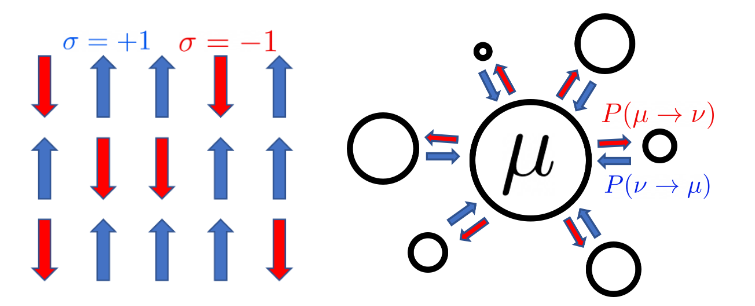

# Algoritmo de Metropolis

$$A(\mu\rightarrow\upsilon)=\left\lbrace\begin{array}{c} 1~si~E_\upsilon<E_\mu\ \\ e^{-\beta (E_\upsilon-E_\mu)} ~si~E_\upsilon<E_\mu\ \end{array}\right.$$

1. Preparamos una configuración inicial de N espines.
2. Selecionamos un espin al azar y cambiamos su polaridad.
3. Calculamos el cambio de energía.
4. Si $\Delta E<0$, acepta el movimiento. De lo contrario, acepte el movimiento con probabilidad $e^{-\beta(E_\upsilon-E_\mu)}$. Esto satisface la condición de equilibrio detallada, asegurando un estado de equilibrio final.

# MODELO DE ISING 1D

In [226]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib import patches as pt
import numba 
from numba import njit #Acelerar los calculos de las interacciones
from scipy.ndimage import convolve, generate_binary_structure  #Para obtener la energia del sistema
plt.style.use(['science','notebook', 'grid']) #Estilo para presentacion de graficos

In [227]:
N = 120  #Numero de spines
Spin_valores = np.array([1,-1]) #Valores que pueden tomar los spines
Spin_array = np.random.choice(Spin_valores,size = N) #devuelve un arreglo con valores +1 y -1 en posiciones aleatorias

In [228]:
#Spin_valores
Spin_array

array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,
        1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1,
        1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,
        1])

In [229]:
##Parametros definidos a conveniencia
J = 1 #Factor de iteracción
T = 0.05 #Temperatura baja
Beta = 1.0/T #Constante de normalización

In [230]:
## Calculo de la energía inicial del sistema. 
energía = 0
for i in range(N-1): #desde 1 hasta 120
    energía += -J*Spin_array[i]*Spin_array[i+1]
E = [energía]    ##Almacena el valor de la energía en una lista
#print('Energía inicial E = ', energía )

In [231]:
##Magnetización Inicial
m = np.sum(Spin_array) #Magnetizacion
Mag = [m]  #Lista para almacenar la magnetización
#print('Magnetización Inicial M  = ', m )

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45035.67it/s]


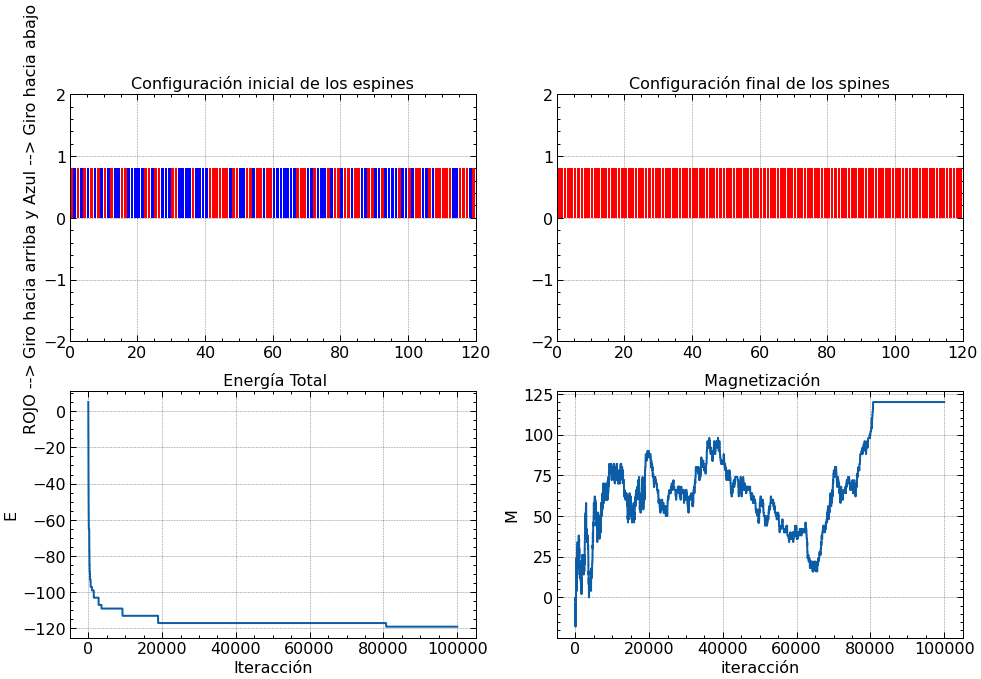

In [232]:
def spin_color(SS):   ##  función que representa los giros. el giro hacia abajo es azul y el giro hacia arriba es rojo
    if SS==-1: return 'b';
    else: return 'r'
    
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols= 2,figsize = (16,10)) ##Creamos figuras

#Grafico 01 
ax1.set_xlim(0,N)  
ax1.set_ylim(-2,2)
ax1.set_ylabel("ROJO --> Giro hacia arriba y Azul --> Giro hacia abajo")
ax1.set_title("Configuración inicial de los espines")

for i in range(N):
    PP = pt.Rectangle((i,0), 0.8, 0.8, fc = spin_color(Spin_array[i])) #Crea un rectangulo con (punto anclaje, ancho, alto)
    ax1.add_patch(PP) #Agrega cada rectangulo con su debido color por cada N en el grafico 1.
    
###################################################################################    
######################Algoritmo de Metropolis######################################
###################################################################################
STEP = [0]  #almacenamos cada iteracción.
for i in tqdm(range(100000)): #100000 veces
    r_n = np.random.randint(0,N)  ##Genera numeros aleatorio
    sigma_mu = Spin_array[r_n] ##Determina el valor del espin
    del_m = -2*sigma_mu   #Cambio en la magnetización
    del_E = 0 ##Cambio en la energía
    if(r_n == 0):
        
        del_E =2*J*sigma_mu*(Spin_array[1])  #Derecha             #  ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑  
    elif(r_n == N-1):
        
        del_E = 2*J*sigma_mu*(Spin_array[N-2]) #Izquierdo
    else:
        del_E = 2*J*sigma_mu*(Spin_array[r_n+1]+Spin_array[r_n-1]) #Izquierda - derecha
    
    STEP.append(i)
    
 #cambiar de estado con probabilidades designadas
    if(np.random.uniform()<np.exp(-Beta*del_E)): #valor extraido entre (0 y 1)
        Spin_array[r_n] = -1*Spin_array[r_n]
        energía += del_E
        m+= del_m

    else:
        Spin_array[r_n] =Spin_array[r_n] #Deja el spiin en el estado inicial
        
    E.append(energía)
    Mag.append(m)   

#Estado final    
ax2.set_xlim(0,N)
ax2.set_ylim(-2,2)
ax2.set_title("Configuración final de los spines")

for i in range(N):
    PP = pt.Rectangle((i,0), 0.8, 0.8, fc = spin_color(Spin_array[i]))
    ax2.add_patch(PP)
    
    
    
## Grafico energía vs pasos para anlizar el equilibrio   
ax3.set_title(" Energía Total")
ax3.set_xlabel("Iteracción")
ax3.set_ylabel("E")
ax3.plot(STEP,E)

#Grafico Magnetización vs pasos para anlizar el equilibrio  
ax4.set_title(" Magnetización")
ax4.set_xlabel("iteracción")
ax4.set_ylabel("M")
ax4.plot(STEP,np.array(Mag))
plt.show()

#print("Energía Final=", E[iter])

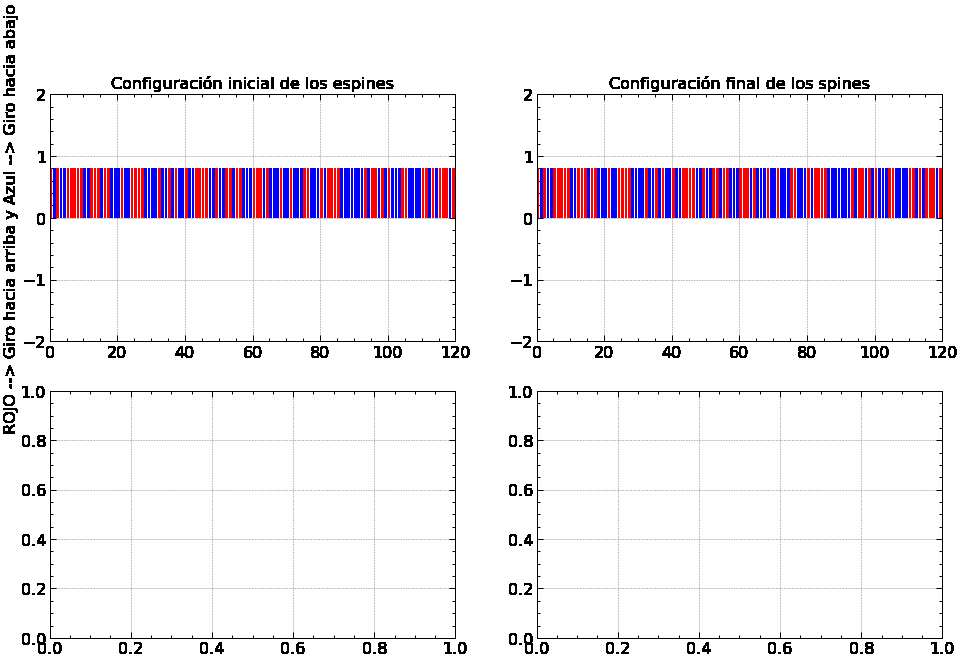

# MODELO DE ISING 2D

In [187]:
# 50 by 50 grid #Cuadricula de giros de 50 por 50
N = 50

In [188]:
init_random = np.random.random((N,N)) #Genera cuadriculas aleatoreas
rejilla_n = np.zeros((N, N)) #Devuelve una matrix de ceros para inicializar
rejilla_n[init_random>=0.75] = 1 #configuramos valores para +1
rejilla_n[init_random<0.75] = -1 #configuramos valores para -1

init_random = np.random.random((N,N))
rejilla_p = np.zeros((N, N))
rejilla_p[init_random>=0.25] = 1 #configuramos valores para +1
rejilla_p[init_random<0.25] = -1 #configuramos valores para -

In [189]:
#init_random 
#rejilla_n
rejilla_p

array([[-1., -1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1.,  1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1., -1., ...,  1., -1.,  1.]])

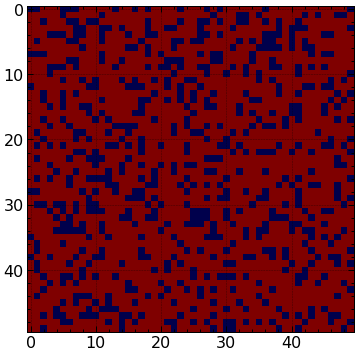

In [190]:
plt.imshow(rejilla_p, cmap='seismic') #Debuelve inmagen 2D utilizando los datos, grfica datos como imagnen
plt.show()

Energía inicial: $$ 
\mathcal{H} = -J \sum_{\langle i j \rangle} S_{i} S_{j} \hspace{2 cm} \frac {\mathcal{H}}{J} = - \sum_{\langle i j \rangle} S_{i} S_{j} $$     

In [199]:
#kern = generate_binary_structure(2, 1)
#kern[1][1] = False

In [200]:
#kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [193]:
def Obtener_energia(rejilla):
    #Se aplica la suma d elos vecinos mas cercanos                               ↑ ↑ ↑     ↑ 
    kern = generate_binary_structure(2, 1)  #Convolucion del sistema             ↑ ↑ ↑   ↑ ↑ ↑
    kern[1][1] = False                                                     #     ↑ ↑ ↑     ↑ 
    arr = -rejilla * convolve(rejilla, kern, mode='constant', cval=0) 
    return arr.sum()

In [194]:
Obtener_energia(rejilla_p)

-2092.0

In [195]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True) #Para Mejora el rendimiento
def metropolis(spin_arr, tiempos, BJ, energy): 
    spin_arr = spin_arr.copy() #Copia de la configuración inicial
    net_spins = np.zeros(tiempos-1) #Matriz vacia
    net_energy = np.zeros(tiempos-1) #Matriz vacia
    for t in range(0,tiempos-1):
        #2. Elija un spin aleatorio en la matriz y cambiamos su giro
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #espin inicial
        spin_f = spin_i*-1 #Se propone el giro
        
        #Calcula el cambio de energia
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
         #cambiar de estado con probabilidades designadas
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy #Magnetizacion y energia final

C:\Users\Dell\anaconda3\lib\site-packages\numba\core\decorators.py:260: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [196]:
spins, energies = metropolis(rejilla_n, 1000000, 0.7, Obtener_energia(rejilla_n)) #Evaluar en el algoritmo de metropolis

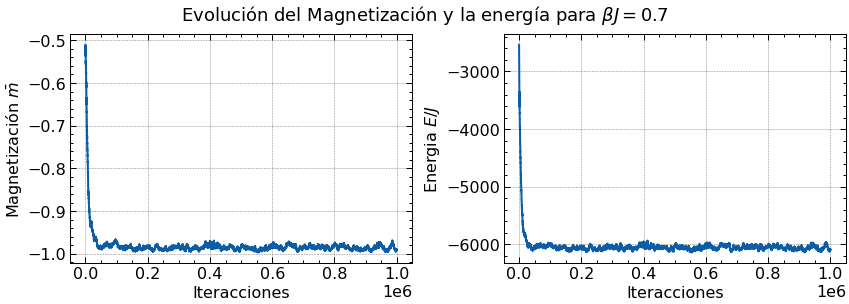

In [198]:
##Graficos
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Iteracciones')
ax.set_ylabel(r'Magnetización $\bar{m}$')
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Iteracciones')
ax.set_ylabel(r'Energia $E/J$')
fig.tight_layout()
fig.suptitle(r'Evolución del Magnetización y la energía para $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [153]:
#Hacemos estadistica
def get_spin_energy(rejilla, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in tqdm(enumerate(BJs)):
        spins, energies = metropolis(rejilla, 1000000, bj, Obtener_energia(rejilla)) #Evalua en algoritmo metropolis
        ms[i] = spins[-100000:].mean()/N**2 #Utilizamoslas ultimas 100000 iteracciones.
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
       
    return ms, E_means, E_stds

BJs = np.arange(0.1, 2, 0.05) #Diferentes temperaturas en el tiempo
ms_n, E_means_n, E_stds_n = get_spin_energy(rejilla_n, BJs) #Rejilla Negativa 75%
ms_p, E_means_p, E_stds_p = get_spin_energy(rejilla_p, BJs)  #Rejilla positiva 75%

38it [02:54,  4.59s/it]
38it [02:55,  4.63s/it]


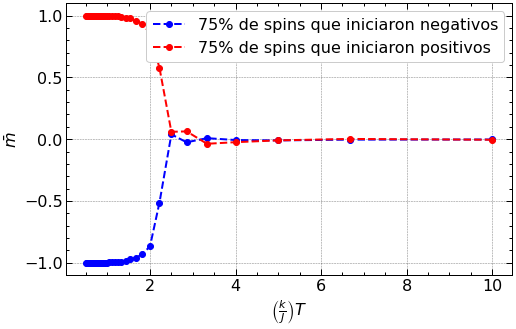

In [155]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--b', label='75% de spins que iniciaron negativos')
plt.plot(1/BJs, ms_p, 'o--r', label='75% de spins que iniciaron positivos')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()